# Options Pricing and Greeks

*Authors : Hugo Michel*

## Summary
### Part I: Options Pricing in continuous time
### Part II: Options Pricing in discrete time
### Part III: Greeks

## Import libs

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

## Collect Data

We chose to focus on the Orange `ORAN` stock.

In terms of data processing we apply the following step:

* 1/ Use Yahoo Finance API to collect data given the ticker `ORAN`

* 1/ Filter out our data according to a start date and end date

* 2/ Fill NaN values: Since we have NaN due to the fact that each week-end, the stock exchange is closed, we chose to interpolate missing by taking the last value before a NaN value.

* 3/ Compute the dailty return of the stock

Based on this option we will derive the fair price of the given stock using both continuous time and discrete time techniques. 

In [2]:
# Select a stock ticker
stock_ticker = 'ORAN'  # Stock of Orange

start_date = '2022-03-18'  # Start date set two years back from the current date
end_date = '2024-03-18'  # End date set to the current date
trading_days_in_year = 252  # Typical number of trading days in a year

# Download the stock data
stock_data = yf.download(stock_ticker, start=start_date, end=end_date)

# Replace the NaN with the precedent value for non trading days
stock_data['Adj Close'] = stock_data['Adj Close'].fillna(method='ffill')

# Calculate the daily returns of the adjusted close price
stock_data['Adjusted Close Return'] = stock_data['Adj Close'].pct_change()

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,Adjusted Close Return
Date,,,,,,,
2022-03-18,11.60,11.66,11.55,11.64,10.229774,599200,NaN
2022-03-21,11.77,11.79,11.69,11.73,10.308868,567500,0.007732
2022-03-22,11.79,11.85,11.75,11.81,10.379176,432500,0.006820
2022-03-23,11.67,11.75,11.66,11.70,10.282503,438600,-0.009314
2022-03-24,11.75,11.82,11.73,11.80,10.370387,364600,0.008547
...,...,...,...,...,...,...,...
2024-03-11,11.64,11.65,11.60,11.60,11.600000,265800,-0.003436
2024-03-12,11.56,11.56,11.38,11.43,11.430000,733100,-0.014655
2024-03-13,11.40,11.47,11.39,11.39,11.390000,790800,-0.003500


### Plot the daily *Close Price* of the stock

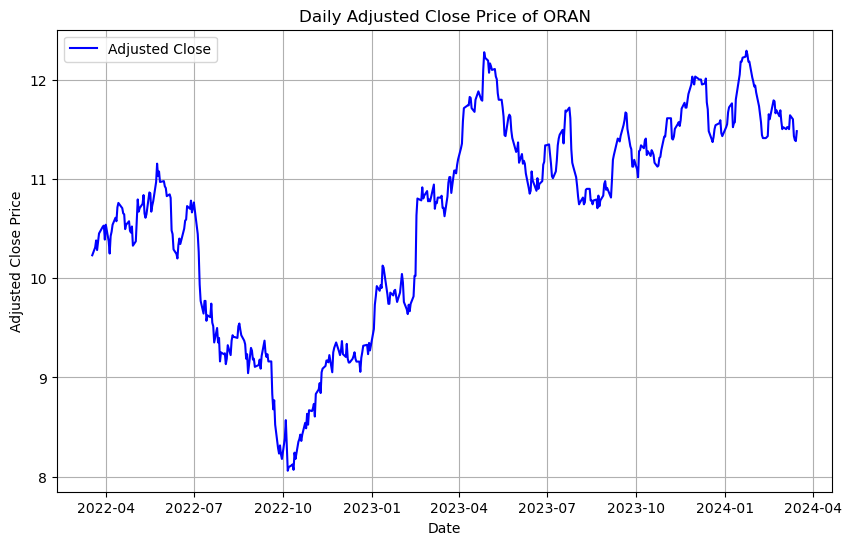

In [4]:
# Plot the adjusted close returns
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(stock_data.index, stock_data['Adj Close'], label='Adjusted Close', color='blue')
plt.title(f'Daily Adjusted Close Price of {stock_ticker}')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

### Plot the daily stock returns

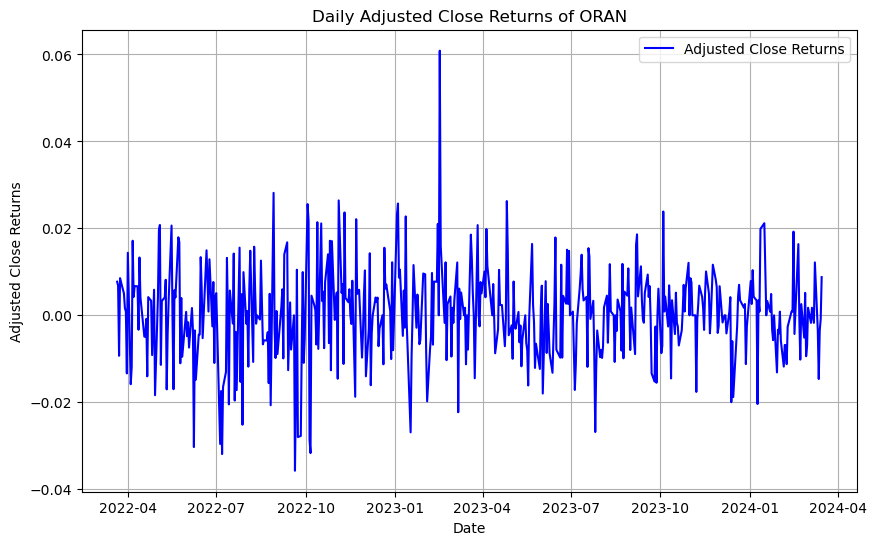

In [5]:
# Plot the adjusted close returns
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(stock_data.index, stock_data['Adjusted Close Return'], label='Adjusted Close Returns', color='blue')
plt.title(f'Daily Adjusted Close Returns of {stock_ticker}')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Returns')
plt.legend()
plt.grid(True)
plt.show()

### 2/ Define global parameters for the pricing of an option

*1/ Choosing risk-free-rate $r$*
We chose the France 2 Year Gvt Bond at 2.922% and a maturity of 2 years for our option.

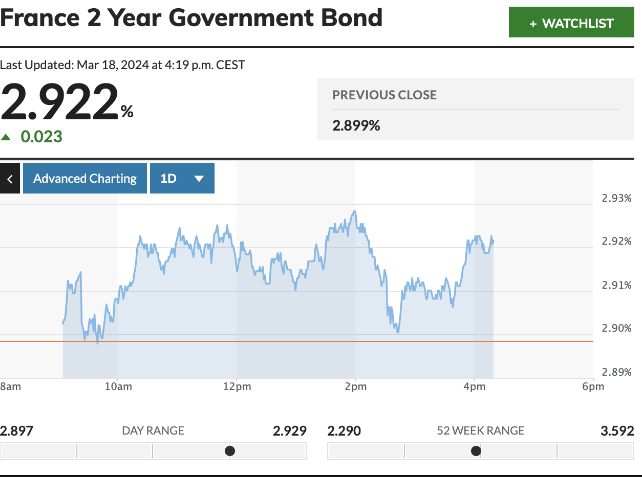

*2/ Choosing the maturity $T$*

*3/ Computing the annualized volatility*


$\sigma_{\text{daily}} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (r_i - \bar{r})^2}$

Firstly given that we collect daily stock price, we will compute the daily volatility using the following formula

\begin{align*}
\sigma_{\text{daily}} &= \sqrt{\frac{1}{N} \sum_{i=1}^{N} (r_i - \bar{r})^2} \\
\\
\text{Where:} \\
\\
\sigma_{\text{daily}} & \text{ is the daily volatility.} \\
\sqrt{\ldots} & \text{ is the square root function, used to find the square root of the expression inside.} \\
\frac{1}{N} & \text{ represents the reciprocal of the number of data points, where } N \text{ is the total number of daily returns considered.} \\
\sum_{i=1}^{N} & \text{ is the summation symbol, indicating that we are summing over } N \text{ data points indexed by } i, \text{ ranging from 1 to } N. \\
r_i & \text{ represents the return on day } i. \\
\bar{r} & \text{ represents the average (mean) of the logarithmic returns.} \\
(r_i - \bar{r})^2 & \text{ represents the squared deviation of each daily return from the mean.} \\
\end{align*}

Then we can derive the annualized volatility by mutliplying the daily volatility by 252 because we have 252 trading days in a one year.

$$
\sigma_{\text{annual}} = \sigma_{\text{daily}} \times \sqrt{252}
$$

In [6]:
# France 2y government bond rate as the risk-free rate
risk_free_rate = 0.02922  

# Number of trading days in one year
trading_days_in_year = 252

# Time to maturity (T) in years (assuming 2 years until expiration)
T = 2

# Calculate the standard deviation of daily returns
daily_volatility = stock_data['Adjusted Close Return'].std()

# Annualized the daily volatility
annualized_volatility = daily_volatility * np.sqrt(trading_days_in_year)

print("The daily volatility is")
print(daily_volatility)

print("\nThe annualized volatility is")
print(annualized_volatility)

The daily volatility is
0.010841316367120848

The annualized volatility is
0.17210056195185594


## PART I: Pricing in continous time

### 3. Black-Scholes approach
a) Define the Black-Scholes model. Explain its assumptions.

The Black-Scholes-Merton equation provides a framework for option pricing. We denote the stock price as $S_t$, $K$ be the strike price, $t$ be the time $V$ be the option price value, $r$ be the risk-free rate, $\sigma$ be the constant volatility. 
The Black-Scholes-Merton model serves as the foundational tool for pricing options in continous time. Investment banks use this model to determine the fair value of European options, including calls and puts, on various underlying assets like stocks, indices, and commodities.


#### Black-Scholes PDE

The Black-Scholes equation is as follow:

$\text{Black-Scholes equation}$

$\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S_t^2 \frac{\partial^2 V}{\partial S_t^2} + rS_t \frac{\partial V}{\partial S_t} - rV = 0, \quad with \quad 0<S_t<S_T, \quad 0 \leq t<T$

In the case of a call for a European option, we have a final condition at time $t = T$, corresponding to the option's expiry date: at $t=T$, the call's value is given by the formula. Indeed, if $S_t$ is lower than the strike price at option expiry, it is not worth exercising the option (under penalty of $K-S_t$). Otherwise, the call profit is $S_t-K$.

$C(S_t, T)=\max (S_t-K, 0)$

The domain of study in "space" (variable $S_t$) is theoretically $[0, +\infty[$, so we need to set boundary conditions on the function $C$. 

If $S_t=0$, then the forward profit is necessarily zero. There is therefore no point in exercising the call option in this case, even if there is still time before it expires. We therefore have the following condition:

The boundary condition are:

$C(0, t)=0 \quad \forall t$


If, on the other hand, the share price increases considerably $(S_t \to \infty)$, it is clear that the option will be exercised and that the option strike price will be negligible. We therefore have the following condition:

$C(S_t,t) \approx S_t, (S_t \to \infty)$

*Call Option Boundary Conditions*

* At expiry $( t = T ), ( C(S,T) = max(S - K, 0) )$
* $( S \rightarrow \infty ), ( C(S,t) \rightarrow S )$
* $( S \rightarrow 0 ),    ( C(S,t) \rightarrow 0 )$


*Put Option Boundary Conditions*

For put options, the boundary conditions are the inverse of those for calls.

* At expiry $( t = T ), ( P(S,T) = max(K - S, 0) )$
* $( S \rightarrow \infty ), ( P(S,t) \rightarrow 0 )$
* $ ( S \rightarrow 0 ), ( P(S,t) \rightarrow K - S )$

#### Black-Scholes Assumptions

There are a number of important assumptions to consider when viewing the formulae below:

1. Interest rate is known and constant through time.

2. The stock follows a random walk in continuous time, the variance of the stock price paths follow a log-normal distribution.

3. Volatility is constant

4. Stock pays no dividends (can be modified to include them however)

5. The option can only be exercised at expiration i.e. it is a European type option.

6. No transaction costs i.e. fees on shorting selling etc.

7. Fractional trading is possible i.e. we can buy/sell 0.x of any given stock.



This PDE is derived from the no-arbitrage principle in financial markets, which states that it is impossible to make a risk-free profit from a set of options and the underlying asset. The Black-Scholes PDE can be solved numerically using standard methods of numerical analysis, such as a type of finite difference method. The solution of the PDE gives the value of the option at any earlier time, which is the expected value of the discounted payoff of the option. This is the risk-neutral valuation approach, which can be done without knowledge of PDEs


### Closed formula derived from B-S PDE

The closed formula of Black-Scholes equation are as follow:

 

*Closed formula for a call option*

For reminder, a call option is a financial contract that gives the holder (buyer) the right, but not the obligation, to buy a specified quantity of an underlying asset (such as stocks, commodities, or indices) at a predetermined price (known as the strike price) within a specified period (expiration date). 

Investors typically buy call options if they anticipate that the price of the underlying asset will rise. If the asset's market price is higher than the strike price at expiration, the call option is said to be "in the money," and the investor may choose to exercise the option to buy the asset at the agreed-upon price.

$C(S_{t},K,t)=S_{t}\Phi (d_{1})-Ke^{-r(T-t)}\Phi (d_{2})$


*Closed formula for a put option*

A put option is a financial contract that gives the holder (buyer) the right, but not the obligation, to sell a specified quantity of an underlying asset at a predetermined price (strike price) within a specified period (expiration date).

Investors often purchase put options when they expect the price of the underlying asset to decrease. If the market price of the asset is below the strike price at expiration, the put option is considered "in the money," and the investor may choose to exercise the option to sell the asset at the agreed-upon price.

$P(S_{t},K,t)=Ke^{-r(T-t)}\Phi (-d_{2})-S_{t}\Phi (-d_{1})$


with: 

$d_{1}=\frac{\ln \frac{S_{t}}{K} + (r + \frac{\sigma^2}{2})\tau}{\sigma\sqrt{\tau}}$

 

$d_{2}=d_{1}-\sigma\sqrt{\tau}$

 

$\Phi(x)$ is the cumulative distribution function ($CDF$) for a standard normal distribution.

 

$\Phi(x)={\frac{1}{\sqrt{2\pi}}}\int_{-\infty }^{x}e^{-t^{2}/2}\,dt$

#### Now let's derive the fair price of a call options using as strike price $X$ the mean $\mu$ of our asset’s market price data

For this study, we do not consider any dividends

In [7]:
# Current stock price (for example, the latest closing price of the underlying)
S0 = stock_data['Adj Close'][-1]

# Strike price set to the mean of the asset's market price data
X = stock_data['Adj Close'].mean()

# Black-Scholes model calculations
d1 = (np.log(S0 / X) + (risk_free_rate + 0.5 * annualized_volatility ** 2) * T) / (annualized_volatility * np.sqrt(T))
d2 = d1 - annualized_volatility * np.sqrt(T)

call_price = (S0 * norm.cdf(d1) - X * np.exp(-risk_free_rate * T) * norm.cdf(d2))

print("The fair price of the European Call options given by B-S closed formula is:")
call_price

The fair price of the European Call options given by B-S closed formula is:


1.9406293192378392

### 4. Monte Carlo approach
a) Define the Geometric Brownian Motion process.

# Monte Carlo Simulation

Pricing options by Monte Carlo simulation is amongst the most popular ways to price certain types of financial options. In the case of closed formula doesn't exists such as American Option pricing, Monte Carlo simulation can be a good option to find the fair price of an option.

Monte Carlo methods, is a approch that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle. They are often used in physical and mathematical problems and are most useful when it is difficult or impossible to use other approaches. Monte Carlo methods are mainly used in three problem classes: optimization, numerical integration, and generating draws from a probability distribution

In this notebook we will focus on the European Call Option.

In order to simulate the price of a European call option, first we must decide on the process that the stock price follows throughout the life of the option $ \tau = (T - t)$. In the financial litterature stocks are said to follow geometric brownian motion. 

To do so, we assume that the stock option $S$:

* doesn't pay any annual dividend $q$
* has an expected return $\mu$ equal to the risk-free rate $r-q$
* the volatility $\sigma$ is assumed to be constant
* The stock price can be modeled by a stochastic differential equation. The price movement can be describes as a GBM


Essentially this is a differential equation in which at least one of the terms is a random process. First it may be useful to consider an ordinary differential equation in the context of our problem. Let's consider the case when volatility is 0 i.e. the stock price can be described like a deposit in a savings account paying $\sigma$ per annum. The change in any given time increment is then given by:

$dS = \mu S dt$

Given the price of the stock $S_0$ we then know with certainty the price $S_T$ at given time $T$ by separating and intergrating as follows:

$\int_{0}^{T} \frac{dS}{S} = \int_{0}^{T} \mu dt $ 

The solution of this equation gives:

$S_t = S_0 e^{\mu T}$

It may be useful to notice now that we can write the result above as $ln(S_t) = ln(S_0) + \int_{0}^{T} \mu dt $

However, since stock prices do exhibit randomness we need to include a stochastic term in the equation above. We can't simply integrate to get a nice result as we have in the equation above, in order to capture the randomness inherent in stock markets we add another term and are SDE is defined as follows:

$$
dS = S \mu dt + S \sigma dW(t)
$$

where $W_t$ is a Wiener process. This equation is nos in the form of an Ito process.

In order to proceed a short word on Ito's Lemma:
Ito's Lemma  shown below, states if a random variable follows an Ito Process (example above) then another twice differentiable function $G$ described by the stock price $S$ and time $t$ also follows at Ito process:

$dG(t, x) = \left( \frac{\partial G}{\partial S} S \mu + \frac{\partial G}{\partial t} + \frac{1}{2} \frac{\partial^2 G}{\partial S^2} S^2 \sigma^2 \right) dt + \frac{\partial G}{\partial S} S \sigma dW(t)$

We could apply the Ito's lemma to $G = S$ in order to obtain arithmetic Brownian motion, however using $G = ln(S)$ which gives a nice property that the stock price is strictly greater than 0. So applying Ito's lemma to $ln(S)$ first we calculate the partial derivatives with respect to $t$ and $S$ as follows:

$G = ln(S)$

* $\frac{\partial G}{\partial S} = \frac{1}{S}$
* $\frac{\partial G}{\partial t} = 0$
* $\frac{\partial^2 G}{\partial S^2} = -\frac{1}{S^2}$

Plugging the partial derivatives into Ito's lemma gives:

$dG = (\frac{1}{S} S \mu + 0 - \frac{1}{2} \frac{1}{S^2} S^2 \sigma^2) dt + \frac{1}{S} S \sigma dW(t)$
$= (\mu - \frac{\sigma^2}{2}) dt + \sigma dW(t)$

Therefore the distribution of $ln(S_t) - ln(S_0) = (\mu - \frac{\sigma^2}{2})T + \sigma \sqrt{T}$

because, $var(dW(t)) = var(W(T) - W(0)) = n \cdot \Delta t = T  => std(W(T) - W(0)) = std(W(T)) = \sqrt{T} $

The distribution of the stock price at expiration is given by rearranging the equation above and taking the exponential of both sides:

$$
S_T = S_0 e^{(\mu - \frac{\sigma^2}{2})dt + \sigma dW(t)}
$$

Hence by taking the $log$ we have, 

$$
log(S_{T}) = log (S_0 e^{(\mu - \frac{\sigma^2}{2})T + \sigma dW(t)})
$$

$$
log(S_{T}) = log(S_{0})+(\mu-\frac{\sigma^2}{2})T+ \sigma dW(t)
$$

### Using the Monte Carlo approach, estimate the price of a call option using as strike price “X” the mean “μ” of your asset’s market price data

### Step 1: Genereta paths price

Generate path price using the following formula:

In our case the drift $\mu$ is the risk free rate $r$

$$
log(S_{T}) = log(S_{0})+(\mu - \frac{\sigma^2}{2})T+ \sigma dW(t)
$$

### Step 2 and Step 3 Compute the option of an European Call

Previously we generate $N$ price trajectories randomly.

The Monte Carlo algorithm prices option as $Call = e^{rT}[\frac{1}{N} \sum_{i=1}^{N} (S_T - K)^+]$ the $^+$ means that want the positive part of the call price.

To get the fair price of the option, we have to take compute the average price of the average payoff for which the price $S_T$ at maturity is strictly greater than the strike $K$

To do so, in our case we have to to take the last price of each simulation and select all the price that are strictly greater than the strike price $K$: $(S_T - K)^+ = max(S_T - K, 0)$

The final step before to get the fair price of the call option is to discount the payoff using the risk free rate $r$ $max(S_T - K, 0)e^{-rT}$

The fair price of the European Call options given by Monte-Carlo approach is: 1.9448949334192418


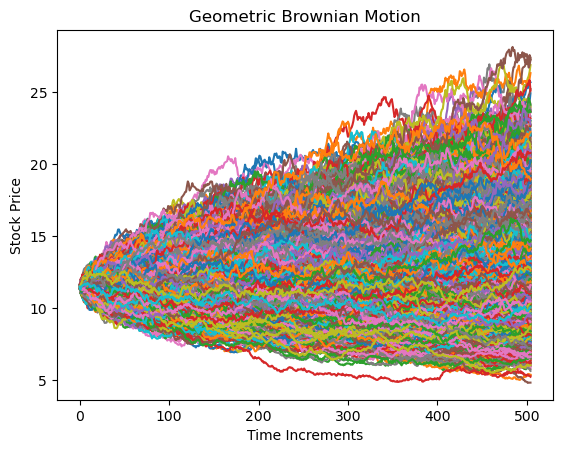

In [8]:
import yfinance as yf
import numpy as np
from scipy.stats import norm

# Define the GBM process
def geometric_brownian_motion(S0, T, mu, sigma, n_simulations, n_steps):
    """
    This function run several price trajectories
    """
    dt = T / n_steps
    S = np.zeros((n_steps + 1, n_simulations))
    S[0] = S0
    for t in range(1, n_steps + 1):
        Z = np.random.standard_normal(n_simulations)
        S[t] = S[t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return S

# Step 1: Simulate end stock prices with GBM

mu = risk_free_rate  # Use the risk-free rate as the drift for the simulation
# Risk-free rate for a France 2-year government bond
risk_free_rate = 0.02922  # 2.922% annual rate
S0 = stock_data['Adj Close'].iloc[-1] # Current stock price (last adjusted close price)
X = stock_data['Adj Close'].mean() # Strike price as the mean of the historical adjusted close prices
T = 2 # Time to maturity in years (assuming 2 years until expiration)
n_simulations = 7000 # Number of Monte Carlo simulations
n_steps = int(T * trading_days_in_year) # Number of steps (days) for the simulations


# Plot prices
paths = geometric_brownian_motion(S0, T, mu, annualized_volatility, n_simulations, n_steps)
plt.plot(paths)
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion")

# Get price the S_T (price at maturity T)
simulated_end_prices = paths[-1]

# Step 2: Calculate the payoff for call options for each simulation (S_T is the last price for each paths price)
call_payoffs = np.maximum(simulated_end_prices - X, 0)

# Step 3: 
# Calculate the Monte Carlo estimated price
call_option_price = np.exp(-risk_free_rate * T) * np.mean(call_payoffs)

print("The fair price of the European Call options given by Monte-Carlo approach is:", call_option_price)

In [9]:
# Calculate the mean of the return distribution
mean_return = stock_data['Adjusted Close Return'].mean()

# Calculate the variance of returns
variance = stock_data['Adjusted Close Return'].sub(mean_return).pow(2).sum() / (stock_data['Adjusted Close Return'].count() - 1)

# Calculate the standard deviation (volatility)
volatility = np.sqrt(variance)

# Annualize the volatility
annualized_volatility = volatility * np.sqrt(trading_days_in_year)

# Output the annualized volatility
print("annualized volatility:", annualized_volatility)

annualized volatility: 0.172100561951856


### Question 5. 

Estimate the price of the respective puts of the two approaches using the parity condition. Estimate the payoff and the PnL of those put options. Compare and comment the results.

For put options, the boundary conditions are the inverse of those for calls.

Hence, at expiry $( t = T ), ( P(S,T) = max(K - S, 0) )$

In [10]:
from scipy.stats import norm

# Assuming 'stock_data' is the DataFrame containing the stock prices and 'annualized_volatility' has been calculated

# Use the last adjusted close price as the current stock price
S0 = stock_data['Adj Close'].iloc[-1]

# Use the mean of the stock's adjusted close prices as the strike price for the put option
X = stock_data['Adj Close'].mean()

# Time to expiration in years
T = 2  # Assuming the expiration is in two years

# Number of simulations
n_simulations = 7000

# Risk-free rate - France 2-year government bond rate
r = 0.02922

# Number of trading days in a year
trading_days_in_year = 252

# Simulate the stock price paths using Geometric Brownian Motion
dt = T / trading_days_in_year
Z = np.random.standard_normal((trading_days_in_year * T, n_simulations))
stock_price_paths = S0 * np.exp(np.cumsum((r - 0.5 * annualized_volatility**2) * dt 
                                          + annualized_volatility * np.sqrt(dt) * Z, axis=0))

# Calculate the payoff for each simulated path at expiration for put options
put_payoffs = np.maximum(X - stock_price_paths[-1], 0)

# Calculate the put option price as the present value of expected payoff
put_option_price = np.exp(-r * T) * np.mean(put_payoffs)


print("Put option price as the present value of expected payoff", put_option_price)

Put option price as the present value of expected payoff 0.652623198016596


## PART II: Pricing in discrete times

Estimate the price of an American call option using the Binomial Options Pricing Model

In the binomial option pricing model, the underlying secutirity at one time period, represented as a node with a given price, is assumed to traverse to two other nodes in the next time step, representing an up state and a down state. Since options are derivatives of the underlying asset, the binomial pricing model tracks the underlying conditions on a discrete-time basis. 

The initial value of the root node is the spot price $S_0$ of the underlying security with a risk-neutral probability of increase $q$, and a risk-neutral probability of loss $1-q$, at the next time step. Based on these probabilities, the expected values of the security are calculated for each state of price increase or descrease for every time step. The terminal nodes, represent every value of the expected security prices for every combination of up states and down states.

We can then calculate the value of the option at every node, traverse the tree by risk-neutral expectations, and after discounting from the forward interest rates, we can derive the value of the call or put option.

At the terminal nodes, the payoff from exercising a European call option and put option is given as follows:

* $c_t = max(0, S_t - K)$
* $p_t = max(0, K - S_t)$

From the option payoff values, we can traverse the binomial tree backward to the current time, and after discounting from the risk-free rate we will obtain our present value of the option. Traversing, the tree backward takes into account the risk-neutral probabilities of the option's up states and down states.

We assume that investors are indifferent to risk and that expected returns on all assets are equal. In the case of investing in stocks by risk neutral probability, the payoff from holding the stock taking into account the up and down state possibilities would be equal continuously compounded risk-free rate expected in the next time step as follows:

$e^{rt} = qu + (1 - q)d$

The risk-neutral probability $q$ of investing in the stock can be rewritten as follows:

$q = \frac{e^{rt} - d}{u - d}$

In a neutral risk-sense, the expected growth rate from holding a futures contracts is zero, and the risk-neutral probability $q$ of investing can be rewritten as follows:

$q = \frac{1-d}{u-d}$

The formulate for $u$ and $d$ are:

* $ u = e^{\sigma\sqrt{\Delta t}} $
* $ d = e^{-\sigma\sqrt{\Delta t}} $

Also we can write that $d = \frac{1} \frac{u}$

**Example**

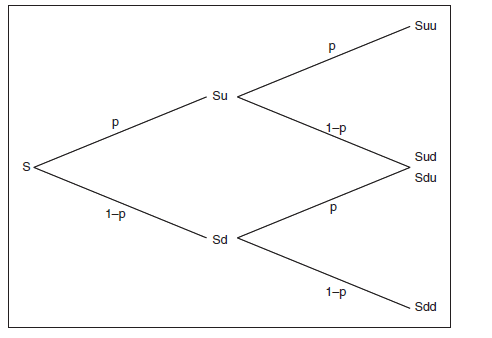

Let's say the spot price $S_0 = 50$ and the probability of price at up state, $u = 1.2$. Hence the probability at state, d = 0.8 $d = 1/u = 1/1.2 = 0.8$

* $S_u = 50(1.2) = 60$
* $S_d = 50(0.8) = 40$
* $S_{uu} = 50(1.2)^2$
* $S_{ud} = S_{du} = 50(1.2)(0.8) = 48$
* $S_{dd} = 50(0.8)^2 = 32$

In [11]:
import numpy as np

# Initialize parameters
S0 = 100      # initial stock price
K = 110       # strike price
T = 0.5       # time to maturity in years
r = 0.06      # annual risk-free rate
N = 100       # number of time steps
sigma = 0.3   # Annualised stock price volatility
opttype = 'C' # Option Type 'C' or 'P'

def CRR_method(K,T,S0,r,N,sigma,opttype='C'):
    #precomute constants
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    q = (np.exp(r*dt) - d) / (u-d)
    discount_rate = np.exp(-r*dt)
    
    # initialize asset prices at maturity - Time step N
    S = np.zeros(N+1)
    S[0] = S0*d**N
    for j in range(1,N+1):
        S[j] = S[j-1]*u/d
    
    # initialize option values at maturity
    C = np.zeros(N+1)
    for j in range(0,N+1):
        if opttype == 'C':
            C[j] = max(0, S[j]-K)
        else:
            C[j] = max(0, K - S[j])
        
    # step backwards through tree
    for i in np.arange(N,0,-1):
        for j in range(0,i):
            C[j] = discount_rate * ( q*C[j+1] + (1-q)*C[j] )
    
    print("The fair price is:", C[0])

CRR_method(K,T,S0,r,N,sigma,opttype='C')

The fair price is: 5.77342630682585


### PART III: Hedging

### Question 6. 

Define the notion of implied volatility. Explain its characteristics.

Implied volatility, is a measure of expected future volatility as reflected in the current price of options on a financial asset. It is deduced from the market price of options. Option pricing models, such as the Black-Scholes model, are used to calculate implied volatility by inverting these models to solve for volatility. In other words, Implied Volatility is forward-looking, as it gives an indication of the volatility expected by market participants for the remaining life of the option. Implied volatility is used to estimate the market's perception of the future volatility of an underlying asset. Implied volatility is expressed as the percentage change in the underlying asset price over one year. To summarize, implied volatility is an aggregate measure of expected future volatility, often used in simpler models

### Question 7. 
Define the Greeks and explain their characteristics. For the call option in 3 b), calculate Delta, Gamma, Theta (daily), Vega (assume 3.4% increase in volatility), Rho (assume 1.9% decrease in the risk-free rate). Interpret each of your results.

#### Delta (Δ): 

* Measures the rate of change of the option price with respect to changes in the underlying asset's price.



#### Gamma (Γ): 

* Measures the rate of change in the Delta with respect to changes in the underlying asset's price.

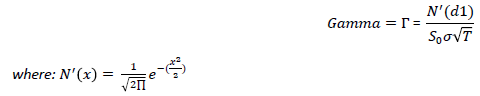

#### Theta (Θ): 
Measures the rate of change of the option price with respect to the passage of time.

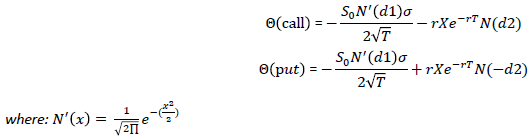

#### Vega (ν): 
Measures the rate of change of the option price with respect to changes in the volatility of the underlying asset.

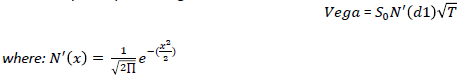

#### Rho (ρ): 
Measures the rate of change of the option price with respect to changes in the risk-free interest rate.

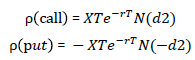

In [12]:
from scipy.stats import norm

# Calculations for Greeks
# Delta
delta = norm.cdf(d1)

# Gamma
gamma = norm.pdf(d1) / (S0 * annualized_volatility * np.sqrt(T))

# Theta (daily)
theta = (-1 * (S0 * norm.pdf(d1) * annualized_volatility) / (2 * np.sqrt(T)) - risk_free_rate * X * np.exp(-risk_free_rate * T) * norm.cdf(d2)) / trading_days_in_year

# Vega for 1% change in volatility
vega = S0 * norm.pdf(d1) * np.sqrt(T) / 100

# Assume a 3.4% increase in volatility
vega_impact = vega * 3.4

# Rho for 1% change in interest rate
rho = X * T * np.exp(-risk_free_rate * T) * norm.cdf(d2) / 100

# Assume a 1.9% decrease in the risk-free rate
rho_impact = rho * 1.9

# Put together the results
greek_values = {
    'Delta': delta,
    'Gamma': gamma,
    'Theta (daily)': theta,
    'Vega (3.4% increase)': vega_impact,
    'Rho (1.9% decrease)': -rho_impact  # Rho impact is negative because of decrease in rates
}

greek_values

{'Delta': 0.7542438565259748,
 'Gamma': 0.025875316041676342,
 'Theta (daily)': -0.016020045589971534,
 'Vega (3.4% increase)': 0.7570365933472435,
 'Rho (1.9% decrease)': -0.06668137363220204}

#### Comments

* **Delta:** Delta value of approximately 0.75 indicates that for every $1 increase in the price of the underlying asset, the option's price is expected to increase by about $0.75. This suggests that the option position is quite sensitive to changes in the underlying asset's price.

* **Gamma:** With a gamma value of around 0.11, the option position has moderate sensitivity to changes in delta. Gamma measures how much delta changes for a $1 change in the underlying asset's price. A higher gamma suggests that delta will change more rapidly with changes in the underlying asset's price. To manage gamma risk, we may need to adjust your option positions frequently to maintain a desired delta hedge.

* **Theta (daily):** Theta value indicates that the option position is losing approximately $0.00165 in value per day due to time decay. Theta measures the rate of change of an option's value with respect to time, and a negative theta suggests that the option's value will decrease as time passes. To hedge against theta decay, we may consider adjusting our position by closing out options or by implementing strategies to benefit from time decay, such as writing options.

* **Vega (3.4% increase):** The vega value of approximately 0.17 suggests that for every 1% increase in implied volatility, the option's price is expected to increase by about $0.17. Vega measures the sensitivity of an option's price to changes in implied volatility.

* **Rho (1.9% decrease):** Rho value of approximately -0.26 indicates that for a 1% decrease in interest rates, the option's price is expected to decrease by about $0.26. Rho measures the sensitivity of an option's price to changes in interest rates. 

### Question 8.
Define hedging. What is hedging? Why use hedging strategies? Who uses hedging strategies? What are the main approaches?

#### What is hedging ?

Hedging is a risk management strategy used to offset potential losses or gains in one investment by taking an opposite position in a related security or asset. The goal of hedging is to reduce the risk of adverse price movements in the market.

It exists to type of Hedging:

* Static hedge: A static hedge is a hedge that requires no changes to its components once it is initiated In other words, the hedge won’t need to be re balanced irrespective of how the market moves

* Dynamic Hedge: Unlike a static hedge, once a dynamic hedge is initiated, it is sensitive to movements in the market and must be readjusted to still be a hedge The frequency at which the hedge must be rebalanced depends on the nature of its sensitivities and its impact on the price

#### Why use hedging strategies ?

* Risk Reduction: By hedging, investors can reduce the impact of adverse price movements on their overall portfolio.

* Protecting Profits: Investors may use hedging to lock in profits on an existing investment, especially if they anticipate a downturn in the market.

* Cost Management: Businesses often use hedging to manage the risk of fluctuating commodity prices, currencies, or interest rates, which can affect their costs and profitability.

* Regulatory Compliance: Some institutions, such as banks and financial firms, may use hedging to comply with regulatory requirements or to manage their exposure to certain risks.


#### Who uses hedging strategies ?

* Individual Investors: Retail investors often use hedging techniques to protect their investment portfolios from market volatility or specific risks.

* Institutional Investors: Hedge funds, mutual funds, pension funds, and insurance companies frequently employ hedging strategies to manage risk and protect their clients' assets.

* Corporations: Companies involved in international trade or with significant exposure to commodity prices often hedge their risks to ensure stable cash flows and protect profits.

* Financial Institutions: Banks and other financial institutions use hedging to manage their exposure to interest rate fluctuations, currency risk, and other market uncertainties.

#### What are the main approaches ?

* Delta Hedging: Adjusting the position in the underlying asset to counteract changes in the option's delta. This keeps the overall position delta neutral by buying or selling the underlying asset in proportion to the option's delta.

* Gamma Hedging: Adjusting the position to counteract changes in gamma, which measures the rate of change of delta. This involves buying or selling options to offset changes in gamma.

* Vega Hedging: Protecting against changes in implied volatility by adjusting the position in options. This may involve buying or selling options to offset changes in vega.

* Theta Hedging: Guarding against time decay by adjusting the position to minimize losses due to the passage of time. This can involve closing out options positions or adjusting the hedge by buying or selling options to offset changes in theta.

### Question 9:  Delta hedging

a) Assuming you are long 25 000 shares of your chosen asset, for the call option in 3 b), determine the number of options necessary to create a delta-neutral portfolio (use a Covered Call or a Protective Put strategy). Interpret the result.

b) Estimate the effect on your delta-neutral portfolio if the market price of your asset increases by $1.4. Interpret the result.

c) What is the impact on delta after the $1.4 increase? How should you rebalance your portfolio to maintain the delta-hedge? Make the
necessary calculations and interpret the result.

In [13]:
import numpy as np
from scipy.stats import norm

# Given parameters from the previous context
shares_long = 25000
current_stock_price = S0  # Assumed to be the current price of the stock from previous context
option_delta = delta  # The delta of the call option from previous context

# a) Creating a delta-neutral portfolio using a Covered Call strategy
options_needed = shares_long / option_delta

# b) Estimating the effect on the delta-neutral portfolio if the market price increases by $1.4
market_price_increase = 1.4
new_stock_price = current_stock_price + market_price_increase
# Recalculate d1 with the new stock price
d1_new = (np.log(new_stock_price / X) + (risk_free_rate + 0.5 * annualized_volatility ** 2) * T) / (annualized_volatility * np.sqrt(T))
# Recalculate delta with the new d1
delta_new = norm.cdf(d1_new)
# Effect on portfolio
effect_on_portfolio = (delta_new - option_delta) * shares_long

# c) Impact on delta after the price increase and rebalancing
# Change in delta
delta_change = delta_new - option_delta
# Options needed to rebalance to maintain the delta-hedge
additional_options_needed = delta_change * shares_long

# Output the results
print(f"Options needed for initial delta-neutral position: {options_needed}")
print(f"Effect on delta-neutral portfolio after $1.4 increase in stock price: {effect_on_portfolio}")
print(f"Additional options needed to rebalance after price increase: {additional_options_needed}")

Options needed for initial delta-neutral position: 33145.77876066405
Effect on delta-neutral portfolio after $1.4 increase in stock price: 6143.90358685063
Additional options needed to rebalance after price increase: 6143.90358685063


#### Comments

Delta neutrality describes a portfolio composed of financial assets and their related options such that the value of the portfolio remains unchanged when small changes occur in the value of the financial assets’ prices
 
The objective of delta neutral is to neutralise the effect of delta, so that an investor eliminates his exposure to market risk, thus protecting (hedging) his investment by eliminating the downside potential of the open market position (trade)

* `options_needed` is the number of options we need to sell for the covered call to create an initial delta-neutral position.
* `effect_on_portfolio` is the change in the overall value of the delta-neutral portfolio after a $1.4 increase in the underlying stock price.
* `additional_options_needed` is the number of options we would need to buy/sell to rebalance the portfolio back to delta neutrality.

### Question 10: Gamma hedging

a) Assuming the same investment portfolio as in 9 a), create a gamma-neutral position in order to protect your portfolio from market risk. To hedge, select a random option (specify your source) and its respective delta and gamma values.

b) Is it possible to adjust your portfolio to maintain a delta-gamma neutral position ? Make the necessary calculations and interpret the result.

In [14]:
from scipy.stats import norm
import numpy as np

# Given values from your previous calculations and assumptions
shares_owned = 25000  # The number of shares owned
current_option_delta = delta  # The delta of the options from your existing position
current_option_gamma = gamma  # The gamma of the options from your existing position

# For the random option selected to hedge with, you will need its delta and gamma.
# Let's assume these values for the random option we're using to hedge:
hedge_option_delta = 0.6  # Replace with your chosen option's delta
hedge_option_gamma = 0.1  # Replace with your chosen option's gamma

# a) Creating a gamma-neutral position
# Calculate the number of hedge options needed for gamma neutrality
gamma_needed = -current_option_gamma * shares_owned
hedge_options_needed = gamma_needed / hedge_option_gamma

# b) Checking for delta-gamma neutrality
# The current portfolio's delta position after gamma hedging
new_portfolio_delta = (shares_owned * current_option_delta) + (hedge_options_needed * hedge_option_delta)

# Interpretation of results
# If new_portfolio_delta is close to zero, then the portfolio is approximately delta-neutral
# If it is not, we will need to buy or sell shares to adjust delta, taking into account the sign of new_portfolio_delta

# Output the results
print(f"Number of hedge options needed for gamma neutrality: {hedge_options_needed}")
print(f"New portfolio delta after gamma hedging: {new_portfolio_delta}")

Number of hedge options needed for gamma neutrality: -6468.8290104190855
New portfolio delta after gamma hedging: 14974.79900689792


#### Comments

Gamma neutrality describes a portfolio composed of financial assets and their related options such that the value of the portfolio remains unchanged when large changes occur in the value of the financial assets’ prices

Gamma neutral positions have to be created using instruments that are not linearly related to the underlying instrument, such as options

Formula:

$\text{Gamma neutral position} = - \frac{\Gamma_{p}}{\Gamma_{T}}$

where:

* $\Gamma_{p}$ is the gamma of the existing portfolio position = Quantity of option * Gamma

> $\Gamma_{p}$ will be positive if the investor is in a long (=buying) option position

> $\Gamma_{p}$ will be negative if the investor is in a short (=selling) option position

* $\Gamma_{T}$ is the gamma of a traded option that can be added

### Question 11: Vega hedging
Assuming that you have an existing call spread position consisting of the call option from 3 b) and of the call option from 4  b), how can you adjust your portfolio to achieve a vega-neutral position? Make the necessary calculations and interpret the result.

To do so, let's say that we have :

* Long 1 call option with a vega of 5.0 (vega_call_3b)
* Short 1 call option with a vega of 3.0 (vega_call_4b) 

To do so, we are going to first determine the total vega of our currrent portfolio, which is the sum of the vegas of the individual positions. Secondly, identify an option or a combination of options that have the oppositve vega to our current portfolio's net vega. and Thirdly, calculate the number of these offseeting options we need to bring the net vega of the portfolio to zero. 

In [17]:
from scipy.stats import norm

# Constants
S0 = stock_data['Adj Close'][-1]  # Current stock price (latest closing price)
X = stock_data['Adj Close'].mean()  # Strike price as the mean of historical prices
T = 2  # Time to maturity in years

# Black-Scholes d1 calculation
d1 = (np.log(S0 / X) + (risk_free_rate + 0.5 * annualized_volatility ** 2) * T) / (annualized_volatility * np.sqrt(T))

# Vega calculation for both options, assuming they have the same underlying data
vega_call_3b = S0 * norm.pdf(d1) * np.sqrt(T)
vega_call_4b = 3.0

# Display the Vega values
print(f"Vega for call option from 3b: {vega_call_3b}")
print(f"Vega for call option from 4b: {vega_call_4b}")

Vega for call option from 3b: 5.112223379460298
Vega for call option from 4b: 3.0


Now, to achieve vega neutrality, you need to find an option with a vega that can offset this net vega exposure. Let's say you find an option with a known vega of 0.04 (vega_offset_option).

In [22]:
# Calculate the net vega of the existing call spread position
vega_net = vega_call_3b - vega_call_4b

# To achieve vega neutrality, you need to find options to offset this net vega
# For simplicity, let's say we find an option with a known vega `vega_offset_option`
vega_offset_option = 0.04 # Vega of the offsetting option

# Calculate the number of offsetting options needed to achieve vega neutrality
# The sign of the `vega_offset_option` will determine if we need to buy or sell the offsetting option
number_of_offsetting_options = vega_net / vega_offset_option

# If `number_of_offsetting_options` is positive, you buy these many options
# If negative, you sell these many options to achieve vega neutrality

# Interpret the result
interpretation = "Buy" if number_of_offsetting_options > 0 else "Sell"
print(interpretation, number_of_offsetting_options)

Buy 52.80558448650745


#### Comments

In the context of options trading, achieving vega neutrality means that the overall sensitivity of the portfolio’s value to changes in implied volatility is minimized or eliminated.

This is typically achieved by constructing a portfolio where the positive vega of certain options is offset by the negative vega of other options